A partir du fichier téléchargé depuis ActiveTiggers, il faut passer par description_annotations pour créer le fichier avec la phrase, l'id et l'annotation.

In [1]:
import numpy as np
import random
import torch
import sklearn
random_seed = 1968
# Set random seed for NumPy
np.random.seed(random_seed)

# Set random seed for Python built-in random module
random.seed(random_seed)

# Set random seed for PyTorch
torch.manual_seed(random_seed)

# Set random seed for Scikit-learn
sklearn.utils.check_random_state(random_seed)


RandomState(MT19937) at 0x1F648ACCB40

# Preping annotations

In [2]:
import pandas as pd

current_annotations_file = "../../data/intermediate/annotations/personne_withSentence_1400annotations_2024-07-15_ActiveTigger.csv"

annotations_file = pd.read_csv(current_annotations_file, dtype = {'sentence_id':'int', 
'Personne':'str','sentence':'str'}).set_index('sentence_id')

annotations_file.head(5)

,Personne,sentence
sentence_id,,
1220587,Personne responsable et autonome,Il importe donc de tenir compte de toutes les ...
1291195,Personne responsable et autonome,Le principe fondamental d’une garantie humaine...
1360306,Personne responsable et autonome,Ces personnes donnent un consentement qui relè...
580205,Personne responsable et autonome,"Sur le plan éthique, cette évolution peut être..."
700014,Personne responsable et autonome,C'est dans ce cadre que peut se\nposer la ques...


In [3]:
system_prompt = """Tu es un expert en éthique qui doit classifier des phrases présentes dans les textes d'un comité de bioéthique. Le but est de comprendre le traitement de la personne/de l'individu/de l'humain dans ces questionnements éthiques. 
Tu dois classifier une phrase en français parmi l'une des catégories suivantes : Corps humain, Genre/espèce humaine, Individu ou sujet, Personne à protéger, Personne relationnelle, Personne responsable et autonome, Poubelle, Sentiment humain. 
Ne fais pas une phrase complète, ni ne donne de justification, juste donne l'intitulé de la catégorie.
Voici une courte description de chaque catégorie :
Corps humain = tout ce qui réfère directement au corps humain, comme le matériel biologique, des explications biologiques ou les débats autour du statut de l'embryon.
Genre/espèce humaine = tout ce qui relève de ce que l'humanité partage en commun, le fait d'être un être humain et de ce que l'humanité partage avec le reste du vivant, en particulier mais pas que les questions d'écologie.
Individu ou sujet = tout ce qui relève de la statistique, ou de l'économie, compter les gens, faire des essais en double aveugle, ou en parler comme d'une population à gérer, ou les calculs bénéfices risques. Par exemple, la gestion des prisons fait partie de cette catégorie, ou encore la gestion du système de santé. Cette catégorie inclut aussi les cas où la raison public est supérieure à l'individu ou certaines questions de gestion d'épidémie.
Personne à protéger = tout ce qui relève de l'idée de protection de la personne, en particulier dans un sens médicale. Le médecin est responsable du patient, et pas le patient de lui-même. Cela inclut par exemple mais pas que : le respect de la personne, ou le fait de la protéger contre son manque d'autonomie, ou encore le fait de faire respecter le droit de la personne.
Personne responsable et autonome = tout ce qui relève de conserver l'autonomie de la personne ou de traiter la personne comme un agent responsable de ses actes, en particulier une responsabilité juridique (comme une personne qui doit donner son consentement). S'applique aussi quand la personne est capable de se déterminer grâce à l'entourage, grâce à ses relations par exemple avec le personnel médical.
Personne relationnelle = quand la personne est définie par son entourage, ou quand son entourage est important. Par exemple, si on parle d'une personne de confiance ou collégialité. Cette catégorie est aussi une catégorie intermédiaire entre personne à protéger et personne responsable et autonome.
Sentiment humain = catégorie plus rare mais importante qui inclut les cas où ce sont les sentiments que nous éprouvons en tant qu'humain qui sont importants comme la dignité, l'empathie.
Poubelle = catégorie à utiliser si et seulement si le texte ne réfère pas à la personne (erreur de frappe comme personne l ou personne lle).
Si une incertitude persiste, concentre toi moins sur le contexte de la phrase que sur la façon dont la personne est envisagée dans la phrase.
"""
user_prompt = """
A quelle catégorie appartient la phrase que je te donne parmi les catégories suivantes : Corps humain, Genre/espèce humaine, Individu ou sujet, Personne à protéger, Personne relationnelle, Personne responsable et autonome, Poubelle, Sentiment humain. 
Ne fais pas une phrase complète, ni ne donne de justification, juste donne l'intitulé de la catégorie.
La phrase à classifier est la suivante :

"""
print(system_prompt)
print(user_prompt)

Tu es un expert en éthique qui doit classifier des phrases présentes dans les textes d'un comité de bioéthique. Le but est de comprendre le traitement de la personne/de l'individu/de l'humain dans ces questionnements éthiques. 
Tu dois classifier une phrase en français parmi l'une des catégories suivantes : Corps humain, Genre/espèce humaine, Individu ou sujet, Personne à protéger, Personne relationnelle, Personne responsable et autonome, Poubelle, Sentiment humain. 
Ne fais pas une phrase complète, ni ne donne de justification, juste donne l'intitulé de la catégorie.
Voici une courte description de chaque catégorie :
Corps humain = tout ce qui réfère directement au corps humain, comme le matériel biologique, des explications biologiques ou les débats autour du statut de l'embryon.
Genre/espèce humaine = tout ce qui relève de ce que l'humanité partage en commun, le fait d'être un être humain et de ce que l'humanité partage avec le reste du vivant, en particulier mais pas que les questi

In [4]:
# Step 1: Concatenate user_prompt with sentence
annotations_file['full_question'] = "Pour la phrase d'identifiant id:" + annotations_file.index.astype(str) + ';\n' + user_prompt + '\n' + annotations_file['sentence']

annotations_file.sample(5)


,Personne,sentence,full_question
sentence_id,,,
1290246,Genre/espèce humaine,De véritables sauts qualitatifs sont en \ncour...,Pour la phrase d'identifiant id:1290246;\n\nA ...
1430748,Personne relationnelle,La personne de confiance pourrait \nd’ailleurs...,Pour la phrase d'identifiant id:1430748;\n\nA ...
1420173,Personne à protéger,- La difficul té à subir des examens pour les ...,Pour la phrase d'identifiant id:1420173;\n\nA ...
220007,Corps humain,"Seule, la thérapie génique somatique (1) peut\...",Pour la phrase d'identifiant id:220007;\n\nA q...
110038,Personne responsable et autonome,Sujets humains étudiés\nPlutôt que de proposer...,Pour la phrase d'identifiant id:110038;\n\nA q...


# Export jsonl

In [5]:
from sklearn.model_selection import train_test_split

resave = True
# Step 2: Separate train and test split, stratifying by annotation categories
train, test = train_test_split(annotations_file[["full_question","Personne"]], 
                               stratify=annotations_file['Personne'], random_state=random_seed)

def dataframe_to_json(system_prompt, dataframe):
    json_data = []
    for _, row in dataframe.iterrows():
        messages = []
        messages.append({"role": "system", "content": system_prompt})
        messages.append({"role": "user", "content": row['full_question']})
        messages.append({"role": "assistant", "content": row['Personne']})
        json_data.append({"messages": messages})
    return json_data

train_json = dataframe_to_json(system_prompt=system_prompt,dataframe=train)
test_json = dataframe_to_json(system_prompt=system_prompt,dataframe=test)

import json

if resave:
    # Save train_json
    with open('../../data/intermediate/big/gpt/train.jsonl', 'w') as f:
        for item in train_json:
            json.dump(item, f)
            f.write('\n')

    # Save test_json
    with open('../../data/intermediate/big/gpt/test.jsonl', 'w') as f:
        for item in test_json:
            json.dump(item, f)
            f.write('\n')


# redo test and confusion matrix    

In [6]:
test.sample()

,full_question,Personne
sentence_id,,
1330004,Pour la phrase d'identifiant id:1330004;\n\nA ...,Corps humain


In [7]:
from openai import OpenAI
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

rerun = False

# Set up your OpenAI API key
client = OpenAI(
    api_key = ""
)

# Load your test set
texts = test['full_question'].tolist()
true_labels = test['Personne'].tolist()

# Get unique labels from true labels
unique_labels = list(pd.Series(true_labels).unique())
unique_labels.append("Miscellaneous")

# Function to get predictions from the fine-tuned model
def get_predictions(texts):
    predictions = []
    full_responses = []
    for text in texts:
        response =  client.chat.completions.create(
            model="ft:gpt-3.5-turbo-0125:cmh:ccne-pers-seed1968:9lEciaZR",
            messages = [
                {'role': "system", 'content':system_prompt},
                {'role': "user", 'content':text}
            ]
        )
        full_responses.append(response)
        prediction = response.choices[0].message.content
        predictions.append(prediction)
    return predictions, full_responses

# Get predictions
if rerun:
    predicted_labels, full_responses = get_predictions(texts)
else:
    test = pd.read_pickle('../../data/intermediate/big/gpt/2023_07_15_seed1968_CCNE_pers_gpt_test_with_predictions.pkl')
    predicted_labels = test["Predicted_Label"]
    full_responses = test["Full_response"]

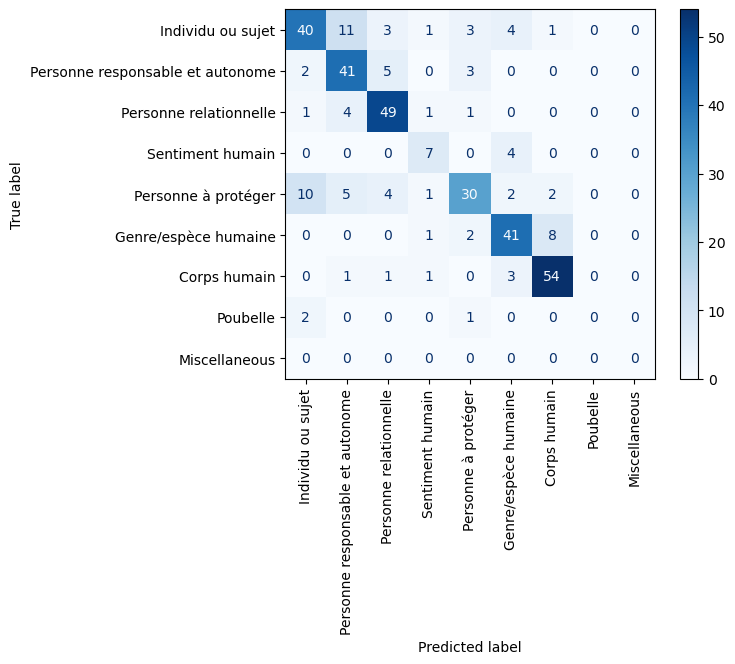

In [8]:
# Handle miscellaneous predictions
corrected_predictions = [
    prediction if prediction in unique_labels else "Miscellaneous"
    for prediction in predicted_labels
]

# Create confusion matrix
cm = confusion_matrix(true_labels, corrected_predictions, labels=unique_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)

# Plot confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90)
plt.show()

In [9]:
# Add predictions to the DataFrame
test['Predicted_Label'] = predicted_labels
test['Corrected_Prediction'] = corrected_predictions
test['Full_response'] = full_responses

# Save the DataFrame as a .pkl file
if rerun:
    test.to_pickle('../../data/intermediate/big/gpt/2023_07_15_seed1968_CCNE_pers_gpt_test_with_predictions.pkl')

In [10]:
pd.set_option('display.max_colwidth', None)

cat_a_corriger = "Corps humain"

test[(test['Corrected_Prediction']!=cat_a_corriger) & (test['Personne']==cat_a_corriger)].join(annotations_file[["sentence"]])[
    ["Corrected_Prediction","sentence"]
    ]

,Corrected_Prediction,sentence
sentence_id,,
1330004,Genre/espèce humaine,"Ces capacités \ninédites des biotechnologies peuvent être perçues comme une voie prometteuse pour \nmieux comprendre le rôle des gènes, la signification des variations observées entre \nindividus, notamment en regard de leur état de santé et, plus généralement, de nouvelles \npossibilités pour réparer le génome (dans le cas de l’homme) ou pour une domestication \nmieux adaptée aux besoins de l’humanité (dans le cas des plantes et des animaux)."
20557,Genre/espèce humaine,"Ces études englobent non seulement des interventions planifiées sur des sujets humains,\nmais des recherches dans lesquelles des facteurs environnementaux sont manipulés d'une\nmanière pouvant constituer un risque pour des individus exposés fortuitement."
1240498,Personne responsable et autonome,"Quand un séquençage \nglobal d’ADN est décidé , un protocole rigoureux \ndoit guider la conduite à tenir pour les déco uvertes non sollicitées.83 \nLa Commission présidentielle pour l’étude des questions de bioéthique aux États -Unis et la S ociété européenne de génétique humaine rappellent la nécessité d’entreprendre une démarche de \ndécision partagée avec les patients au sujet du périmètre de la comm unication d es résultat s des \nexamen s génétiques et des modalités à mettre en œuvre en cas de découvertes incidentes."
1110023,Genre/espèce humaine,"4 l’usage actuel de cadavres dans diverses salles d’exposition 4 ; d’autre part, celle du devenir des \ncollections de vestiges humains au sein des musées, dans un contexte international où ces corps \nsont parfois réclamés pour inhumation par leurs peuples d’origine ."
1140224,Sentiment humain,"Notre société est sensible aux valeurs qui \ntouchent à l’intimité : pudeur, indisponibilité et intégrité du corps humain."
930304,Personne relationnelle,"Il \ny a lieu de considérer que plus le rapport d’intégr ation à l’individu entier est fort, plus il y \na des raisons de penser qu’une éventuelle commercia lisation posera des problèmes \néthiques."


In [11]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Assuming 'test' is your DataFrame containing the true and predicted labels

# Calculate overall metrics
accuracy = accuracy_score(test['Personne'], test['Corrected_Prediction'])
f1 = f1_score(test['Personne'], test['Corrected_Prediction'], average='weighted')
precision = precision_score(test['Personne'], test['Corrected_Prediction'], average='weighted')
recall = recall_score(test['Personne'], test['Corrected_Prediction'], average='weighted')

# Print overall metrics
print("Overall Metrics:")
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}\n")

# Calculate metrics for each category
unique_labels = test['Personne'].unique()
f1_per_category = f1_score(test['Personne'], test['Corrected_Prediction'], average=None, labels=unique_labels)
precision_per_category = precision_score(test['Personne'], test['Corrected_Prediction'], average=None, labels=unique_labels)
recall_per_category = recall_score(test['Personne'], test['Corrected_Prediction'], average=None, labels=unique_labels)

# Create a DataFrame with the metrics
metrics_df = pd.DataFrame({
    'Category': unique_labels,
    'Precision': precision_per_category,
    'Recall': recall_per_category,
    'F1-Score': f1_per_category})

# Display the DataFrame
print(metrics_df)


Overall Metrics:
Accuracy: 0.7485714285714286
F1 Score: 0.7413124026148817
Precision: 0.7429895850863593
Recall: 0.7485714285714286

                           Category  Precision    Recall  F1-Score
0                 Individu ou sujet   0.727273  0.634921  0.677966
1  Personne responsable et autonome   0.661290  0.803922  0.725664
2            Personne relationnelle   0.790323  0.875000  0.830508
3                  Sentiment humain   0.583333  0.636364  0.608696
4               Personne à protéger   0.750000  0.555556  0.638298
5              Genre/espèce humaine   0.759259  0.788462  0.773585
6                      Corps humain   0.830769  0.900000  0.864000
7                          Poubelle   0.000000  0.000000  0.000000


c:\Users\leopo\anaconda3\envs\ccne\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\leopo\anaconda3\envs\ccne\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Prediction

In [ ]:
base_shuffled = pd.read_pickle("../../data/intermediate/big/base_shuffled.pkl")
base_shuffled.sentence_id = base_shuffled.sentence_id.apply(int)

base_shuffled.set_index('sentence_id', inplace= True)

base_shuffled.head(5)

In [14]:
# Step 1: Concatenate user_prompt with sentence
base_shuffled['full_question'] = "Pour la phrase d'identifiant id:" + base_shuffled.index.astype(str) + ';\n' + user_prompt + '\n' + base_shuffled['sentence']

base_shuffled['full_question'].sample(5)


sentence_id
70183                                                                                                                                                                                                                                                                                                                                                                                                                Pour la phrase d'identifiant id:70183;\n\nA quelle catégorie appartient la phrase que je te donne parmi les catégories suivantes : Corps humain, Genre/espèce humaine, Individu ou sujet, Personne à protéger, Personne relationnelle, Personne responsable et autonome, Poubelle, Sentiment humain. \nNe fais pas une phrase complète, ni ne donne de justification, juste donne l'intitulé de la catégorie.\nLa phrase à classifier est la suivante :\n\n\nAinsi donc, on verrait apparaître une catégorie nouvelle: plus tout à fait humaine et pas\nencore animale qui, par le fait de sa régressio

In [ ]:
repredict = True
# Set up your OpenAI API key
client = OpenAI(
    api_key = ""
)

# Load your test set
texts = base_shuffled['full_question'].tolist()

# Get unique labels from true labels
unique_labels = list(pd.Series(true_labels).unique())
unique_labels.append("Miscellaneous")

# Function to get predictions from the fine-tuned model
def get_predictions(texts):
    predictions = []
    full_responses = []
    for text in texts:
        response =  client.chat.completions.create(
            model="ft:gpt-3.5-turbo-0125:cmh:ccne-pers-seed1968:9lEciaZR",
            messages = [
                {'role': "system", 'content':system_prompt},
                {'role': "user", 'content':text}
            ]
        )
        full_responses.append(response)
        prediction = response.choices[0].message.content
        predictions.append(prediction)
    return predictions, full_responses

# Get predictions
if repredict:
    predicted_labels, full_responses = get_predictions(texts)

In [ ]:
if repredict:
    corrected_predictions = [
        prediction if prediction in unique_labels else "Miscellaneous"
        for prediction in predicted_labels
    ]

    base_shuffled['Predicted_Label'] = predicted_labels
    base_shuffled['Corrected_Prediction'] = corrected_predictions
    base_shuffled['Full_response'] = full_responses

In [20]:
if repredict:
    annotations_file["Annotated_Label"] = annotations_file["Personne"]
    base_predicted = base_shuffled.join(annotations_file["Annotated_Label"], on = 'sentence_id', validate="one_to_one")
    base_predicted['Label'] = np.where(base_predicted['Annotated_Label'].isna(), base_predicted['Corrected_Prediction'], base_predicted['Annotated_Label'])
    base_predicted.to_pickle("../../data/intermediate/predictions/predictions_gpt35ft_1400annotations_7classes_2024-07-15.pkl")
    base_predicted.to_csv("../../data/intermediate/predictions/predictions_gpt35ft_1400annotations_7classes_2024-07-15.csv")